In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive
import os
os.chdir("drive/ML/分类/")
!ls

In [0]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
images=[]
labels=[]
def read_image(imageName):
    im = Image.open(imageName).convert('RGB')
    data = np.array(im)
    return data

In [0]:
# 读取在words里面有几个文件夹
text = os.listdir('./resize_data')
# 把文件夹里面的图片和其对应的文件夹的名字也就是对应的字
for textPath in text:
    for fn in os.listdir(os.path.join('resize_data', textPath)):
        if fn.endswith('.jpg'):
            fd = os.path.join('./resize_data', textPath, fn)
            i=0
            print(i)
            i=i+1
            images.append(read_image(fd))
            labels.append(textPath)
            
X = np.array(images)
y = np.array(list(map(int, labels))) 

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=30)

In [11]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
from keras.utils import np_utils
Y_train = np_utils.to_categorical(y_train, 8)
Y_test = np_utils.to_categorical(y_test, 8)
print(X_train.shape)
print(Y_train.shape)

(3200, 224, 224, 3)
(3200, 8)


In [0]:
from keras import backend as K
def Precision(y_true, y_pred):
    """精确率"""
    tp= K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))  # true positives
    pp= K.sum(K.round(K.clip(y_pred, 0, 1))) # predicted positives
    precision = tp/ (pp+ K.epsilon())
    return precision
    
def Recall(y_true, y_pred):
    """召回率"""
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) # true positives
    pp = K.sum(K.round(K.clip(y_true, 0, 1))) # possible positives
    recall = tp / (pp + K.epsilon())
    return recall
 


In [0]:
import matplotlib.pyplot as plt
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.models import Model
from keras.utils import np_utils
from keras.layers import Convolution2D,Activation,MaxPooling2D,Flatten,Dense,Dropout,Input,Reshape,Lambda
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.utils import plot_model
import numpy as np
from keras.callbacks import ModelCheckpoint,EarlyStopping,LearningRateScheduler,ReduceLROnPlateau
 
def sign_sqrt(x):
    return K.sign(x) * K.sqrt(K.abs(x) + 1e-10)

def l2_norm(x):
    return K.l2_normalize(x, axis=-1)

def batch_dot(cnn_ab):
    return K.batch_dot(cnn_ab[0], cnn_ab[1], axes=[1, 1])

def bilinearnet():
    input_tensor = Input(shape=(224,224,3))
    vgg16 = VGG16(weights='imagenet', include_top=False,input_tensor=input_tensor)
#    conv2048 = Convolution2D(filters=2048,kernel_size=(3,3),)
#    vgg16_add_conv_to_2048 = Model(inputs=input_tensor,outputs=)
    resnet50 = ResNet50(weights='imagenet', include_top=False,input_tensor=input_tensor)
    model_vgg16 = Model(inputs=input_tensor,outputs=vgg16.output)
    model_resnet50 = Model(inputs=input_tensor,outputs=resnet50.output)
    model_vgg16.compile(loss='categorical_crossentropy',optimizer='adam')
    model_resnet50.compile(loss='categorical_crossentropy',optimizer='adam')
    
    resnet50_x = Reshape([model_resnet50.layers[-6].output_shape[1]*model_resnet50.layers[-6].output_shape[2],
                          model_resnet50.layers[-6].output_shape[3]])(model_resnet50.layers[-6].output)
    vgg16_x = Reshape([model_vgg16.layers[-1].output_shape[1]*model_vgg16.layers[-1].output_shape[2],
                       model_vgg16.layers[-1].output_shape[3]])(model_vgg16.layers[-1].output)
    
    cnn_dot_out = Lambda(batch_dot)([vgg16_x,resnet50_x])
    
    sign_sqrt_out = Lambda(sign_sqrt)(cnn_dot_out)
    l2_norm_out = Lambda(l2_norm)(sign_sqrt_out)
    flatten = Flatten()(l2_norm_out)
    dropout = Dropout(0.5)(flatten)
    output = Dense(8, activation='softmax')(dropout)
    
    model = Model(input_tensor, output)
    model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9, decay=1e-6),
                  metrics=['accuracy'])
    print(model.summary())
    
    return model

In [0]:
model=bilinearnet()

In [0]:
from keras.callbacks import ModelCheckpoint
model_checkpoint = ModelCheckpoint('Bilinearnet.h5', monitor='val_loss', verbose=1, save_best_only=True)

In [0]:
history=model.fit(X_train, Y_train, batch_size=50, epochs=50, verbose=1,
          validation_data=(X_test, Y_test),callbacks=[model_checkpoint])

In [0]:
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
import math
import time
import sys
import os
import random
import pickle

import numpy as np

import keras
import keras.layers
import keras.applications
import keras.backend
import keras.preprocessing.image
import keras.utils
import tensorflow as tf

import cv2
import PIL
import PIL.Image
import matplotlib.pyplot as plt
from keras.initializers import glorot_normal

def outer_product(x):
    """
    calculate outer-products of 2 tensors

        args 
            x
                list of 2 tensors
                , assuming each of which has shape = (size_minibatch, total_pixels, size_filter)
    """
    return keras.backend.batch_dot(
                x[0]
                , x[1]
                , axes=[1,1]
            ) / x[0].get_shape().as_list()[1] 

def signed_sqrt(x):
    """
    calculate element-wise signed square root

        args
            x
                a tensor
    """
    return keras.backend.sign(x) * keras.backend.sqrt(keras.backend.abs(x) + 1e-9)

def L2_norm(x, axis=-1):
    """
    calculate L2-norm

        args 
            x
                a tensor
    """
    return keras.backend.l2_normalize(x, axis=axis)


def build_model(
    size_heigth=224
    ,size_width=224
    ,no_class=8
    ,no_last_layer_backbone=17
    
    ,name_optimizer="sgd"
    ,rate_learning=1.0
    ,rate_decay_learning=0.0
    ,rate_decay_weight=0.0
    
    ,name_initializer="glorot_normal"
    ,name_activation_logits="softmax"
    ,name_loss="categorical_crossentropy"

    ,flg_debug=False
    ,**kwargs
):
    
    keras.backend.clear_session()
    
    print("-------------------------------")
    print("parameters:")
    for key, val in locals().items():
        if not val == None and not key == "kwargs":
            print("\t", key, "=",  val)
    print("-------------------------------")
    
    ### 
    ### load pre-trained model
    ###
    tensor_input = keras.layers.Input(shape=[size_heigth,size_width,3])
    model_detector = keras.applications.vgg16.VGG16(
                            input_tensor=tensor_input
                            , include_top=False
                            , weights='imagenet'
                        )
    

    ### 
    ### bi-linear pooling
    ###

    # extract features from detector
    x_detector = model_detector.layers[no_last_layer_backbone].output
    shape_detector = model_detector.layers[no_last_layer_backbone].output_shape
    if flg_debug:
        print("shape_detector : {}".format(shape_detector))

    # extract features from extractor , same with detector for symmetry DxD model
    shape_extractor = shape_detector
    x_extractor = x_detector
    if flg_debug:
        print("shape_extractor : {}".format(shape_extractor))
        
    
    # rehape to (minibatch_size, total_pixels, filter_size)
    x_detector = keras.layers.Reshape(
            [
                shape_detector[1] * shape_detector[2] , shape_detector[-1]
            ]
        )(x_detector)
    if flg_debug:
        print("x_detector shape after rehsape ops : {}".format(x_detector.shape))
        
    x_extractor = keras.layers.Reshape(
            [
                shape_extractor[1] * shape_extractor[2] , shape_extractor[-1]
            ]
        )(x_extractor)
    if flg_debug:
        print("x_extractor shape after rehsape ops : {}".format(x_extractor.shape))
        
        
    # outer products of features, output shape=(minibatch_size, filter_size_detector*filter_size_extractor)
    x = keras.layers.Lambda(outer_product)(
        [x_detector, x_extractor]
    )
    if flg_debug:
        print("x shape after outer products ops : {}".format(x.shape))
        
        
    # rehape to (minibatch_size, filter_size_detector*filter_size_extractor)
    x = keras.layers.Reshape([shape_detector[-1]*shape_extractor[-1]])(x)
    if flg_debug:
        print("x shape after rehsape ops : {}".format(x.shape))
        
        
    # signed square-root 
    x = keras.layers.Lambda(signed_sqrt)(x)
    if flg_debug:
        print("x shape after signed-square-root ops : {}".format(x.shape))
        
    # L2 normalization
    x = keras.layers.Lambda(L2_norm)(x)
    if flg_debug:
        print("x shape after L2-Normalization ops : {}".format(x.shape))



    ### 
    ### attach FC-Layer
    ###

    if name_initializer != None:
            name_initializer = eval(name_initializer+"()")
            
    x = keras.layers.Dense(
            units=no_class
            ,kernel_regularizer=keras.regularizers.l2(rate_decay_weight)
            ,kernel_initializer=name_initializer
        )(x)
    if flg_debug:
        print("x shape after Dense ops : {}".format(x.shape))
    tensor_prediction = keras.layers.Activation(name_activation_logits)(x)
    if flg_debug:
        print("prediction shape : {}".format(tensor_prediction.shape))

        

    ### 
    ### compile model
    ###
    model_bilinear = keras.models.Model(
                        inputs=[tensor_input]
                        , outputs=[tensor_prediction]
                    )
    
    
    # fix pre-trained weights
    for layer in model_detector.layers:
        layer.trainable = False
        
        
    # define optimizers
    opt_adam = keras.optimizers.adam(
                    lr=rate_learning
                    , decay=rate_decay_learning
                )
    opt_rms = keras.optimizers.RMSprop(
                    lr=rate_learning
                    , decay=rate_decay_learning
                )
    opt_sgd = keras.optimizers.SGD(
                    lr=rate_learning
                    , decay=rate_decay_learning
                    , momentum=0.9
                    , nesterov=False
                )
    optimizers ={
        "adam":opt_adam
        ,"rmsprop":opt_rms
        ,"sgd":opt_sgd
    }
    
    model_bilinear.compile(
        loss=name_loss
        , optimizer=optimizers[name_optimizer]
        , metrics=["categorical_accuracy"]
    )
    
    
    
    if flg_debug:
        model_bilinear.summary()
    
    return model_bilinear

In [0]:
model = build_model(
            # number of output classes, 8 for CUB200
            no_class = 8

            # pretrained model specification, using VGG16
            # "block5_conv3 "
            ,no_last_layer_backbone = 17
    
            # training parametes
            ,rate_learning=1.0
            ,rate_decay_weight=1e-8
    
            ,flg_debug=True
        )

In [0]:
from keras.callbacks import ModelCheckpoint
model_checkpoint = ModelCheckpoint('vgg-Bilinearnet.h5', monitor='loss', verbose=1, save_best_only=True)

In [0]:
history=model.fit(X_train, Y_train, batch_size=50, epochs=50, verbose=1,
          validation_data=(X_test, Y_test),callbacks=[model_checkpoint])

In [0]:
from keras.models import load_model
from keras.models import Sequential, Model
model.load_weights('vgg-Bilinearnet.h5')

In [0]:
# now all layers are trainable
for layer in model.layers:
    layer.trainable = True

# change LR
opt_sgd = keras.optimizers.SGD(
                lr=1e-3
                , decay=1e-9
                , momentum=0.9
                , nesterov=False
            )
model.compile(
    loss="categorical_crossentropy"
    , optimizer=opt_sgd
    , metrics=["categorical_accuracy"]
)

In [38]:
history=model.fit(X_train, Y_train, batch_size=50, epochs=100, verbose=1,
          validation_data=(X_test, Y_test),callbacks=[model_checkpoint])

Train on 3200 samples, validate on 800 samples
Epoch 1/100
3200/3200 [==============================] - 71s 22ms/step - loss: 0.1465 - categorical_accuracy: 0.9484 - val_loss: 0.2123 - val_categorical_accuracy: 0.9187

Epoch 00001: loss improved from inf to 0.14654, saving model to vgg-Bilinearnet.h5
Epoch 2/100
3200/3200 [==============================] - 56s 18ms/step - loss: 0.0766 - categorical_accuracy: 0.9750 - val_loss: 0.1176 - val_categorical_accuracy: 0.9575

Epoch 00002: loss improved from 0.14654 to 0.07657, saving model to vgg-Bilinearnet.h5
Epoch 3/100
3200/3200 [==============================] - 56s 18ms/step - loss: 0.0370 - categorical_accuracy: 0.9906 - val_loss: 0.0727 - val_categorical_accuracy: 0.9800

Epoch 00003: loss improved from 0.07657 to 0.03696, saving model to vgg-Bilinearnet.h5
Epoch 4/100
3200/3200 [==============================] - 56s 18ms/step - loss: 0.0129 - categorical_accuracy: 0.9994 - val_loss: 0.0683 - val_categorical_accuracy: 0.9737

Epoch 00

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy'])


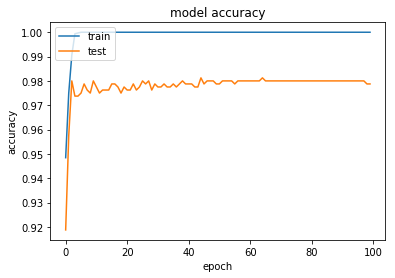

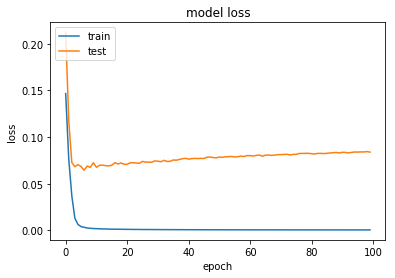

In [40]:
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()